In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import matplotlib.pyplot as plt
#import datatable as dt

In [2]:
os.chdir("C:/Users/Cindy C/Documents/CINDY CHEN/2021 Prep/SCHOOL WORK/Research Project/")

In [3]:
lar2020 = pd.read_csv("2020_lar/2020_lar_ohio_family_loans.csv", sep = " ", dtype = str)
lar2019 = pd.read_csv("2019_lar/2019_lar_ohio_family_loans.csv", sep = " ", dtype = str)
lar2018 = pd.read_csv("2018_lar/2018_lar_ohio_family_loans.csv", sep = " ", dtype = str)

#filter to only certain columns
filter_list = ['activity_year',
               'county_code',
               'applicant_sex',
               'co_applicant_race_1',
               'co_applicant_sex',
               'applicant_age',
               'co_applicant_age',
               'debt_to_income_ratio',
               'combined_loan_to_value_ratio',
               'applicant_race_1',
               'loan_amount',
               'income',
               'loan_term',
               'property_value',
               'action_taken', 
               'ffiec_msa_md_median_family_income',
               'tract_to_msa_income_percentage',
              'loan_purpose']
lar2020 = lar2020.loc[:, filter_list]
lar2019 = lar2019.loc[:, filter_list]
lar2018 = lar2018.loc[:, filter_list]

In [4]:
mortgage = lar2020.append(lar2019, ignore_index = True)
mortgage = mortgage.append(lar2018, ignore_index = True)

In [5]:
mortgage = mortgage[mortgage['loan_purpose'] == '1'] #i only want mortgages that are for buying homes, not refinancings
mortgage.drop(['loan_purpose'], axis = 1, inplace = True)

In [6]:
mortgage['activity_year'] = pd.to_numeric(mortgage['activity_year'], errors = 'coerce')
mortgage['property_value'] = pd.to_numeric(mortgage['property_value'], errors = 'coerce')
mortgage['ffiec_msa_md_median_family_income'] = pd.to_numeric(mortgage['ffiec_msa_md_median_family_income'], errors = 'coerce')
mortgage['loan_amount'] = pd.to_numeric(mortgage['loan_amount'], errors = 'coerce')
mortgage['loan_term'] = pd.to_numeric(mortgage['loan_term'], errors = 'coerce')
mortgage['combined_loan_to_value_ratio'] = pd.to_numeric(mortgage['combined_loan_to_value_ratio'], errors = 'coerce')
mortgage['income'] = pd.to_numeric(mortgage['income'], errors = 'coerce')

In [179]:
mortgage = mortgage[mortgage['loan_term'] != '8888']
mortgage = mortgage[mortgage['loan_term'].isnull() == False]
mortgage = mortgage[mortgage['property_value'].isnull() == False]
mortgage = mortgage[mortgage['income'].isnull() == False]
mortgage = mortgage[mortgage['debt_to_income_ratio'].isnull() == False]
mortgage = mortgage[mortgage['action_taken'].isnull() == False]
mortgage = mortgage[mortgage['combined_loan_to_value_ratio'].isnull() == False]

Recode Action Taken

In [180]:
mortgage['action_taken'] = pd.to_numeric(mortgage['action_taken'], errors = 'coerce')
#filter out everything that's not a mortgage decision
mortgage = mortgage[mortgage['action_taken'] < 4]
conditions = [(mortgage['action_taken'] <= 2), (mortgage['action_taken'] == 3)]
recoded_conditions = [1, 0]
mortgage['action_taken'] = np.select(conditions, recoded_conditions, default = np.nan)

Recode Race

In [181]:
mortgage['applicant_race_1'] = pd.to_numeric(mortgage['applicant_race_1'], errors = 'coerce')

#remove any entries that are 6, 7, 8 because it means that there is no race data
mortgage = mortgage[(mortgage['applicant_race_1'].isnull() == False)]
mortgage = mortgage[(mortgage['applicant_race_1'] != 7)]
mortgage = mortgage[(mortgage['applicant_race_1'] != 6)]

In [182]:
conditions = [(mortgage['applicant_race_1'] == 5), (mortgage['applicant_race_1'] != 5)]
recoded_conditions = [0, 1]
mortgage['applicant_race_1'] = np.select(conditions, recoded_conditions, default = np.nan)
mortgage['applicant_race_1'] = mortgage['applicant_race_1'].astype(object) #convert back to categorical

Recode applicant age to ordinal

In [183]:
mortgage = mortgage[mortgage['applicant_age'] != '8888'] #remove 8888 entries from applicant
mortgage = mortgage[mortgage['applicant_age'] != '9999'] #remove 9999 entries from applicant
mortgage['applicant_age'] = np.where(mortgage['applicant_age'] == '<25', 1,
                                     np.where(mortgage['applicant_age'] == '25-34', 2,
                                              np.where(mortgage['applicant_age'] == '35-44', 3,
                                                       np.where(mortgage['applicant_age'] == '45-54', 4,
                                                                np.where(mortgage['applicant_age'] == '>74', 7,
                                                                         np.where(mortgage['applicant_age'] == '55-64', 5,
                                                                                  np.where(mortgage['applicant_age'] == '65-74', 6,0)))))))

Recode debt to income into an ordinal variable

In [184]:
conditions = [(mortgage['debt_to_income_ratio'] == '<20%'),
              (mortgage['debt_to_income_ratio'] == '20%-<30%'),
              (mortgage['debt_to_income_ratio'] == '30%-<36%'),
              ((mortgage['debt_to_income_ratio'] == '36') | (mortgage['debt_to_income_ratio'] == '37') |
              (mortgage['debt_to_income_ratio'] == '38') | (mortgage['debt_to_income_ratio'] == '39') |
              (mortgage['debt_to_income_ratio'] == '40') | (mortgage['debt_to_income_ratio'] == '41') |
              (mortgage['debt_to_income_ratio'] == '42') | (mortgage['debt_to_income_ratio'] == '43')),
              ((mortgage['debt_to_income_ratio'] == '44') | (mortgage['debt_to_income_ratio'] == '45') |
              (mortgage['debt_to_income_ratio'] == '46') | (mortgage['debt_to_income_ratio'] == '47') | 
              (mortgage['debt_to_income_ratio'] == '48') | (mortgage['debt_to_income_ratio'] == '49')),
              (mortgage['debt_to_income_ratio'] == '50%-60%'),
             (mortgage['debt_to_income_ratio'] == '>60%'),
             (mortgage['debt_to_income_ratio'] == "Exempt")]
recoded_conditions = [1, 2, 3, 4, 5, 6, 7, "Exempt"]
mortgage['debt_to_income_ratio'] = np.select(conditions, recoded_conditions, default = np.nan)

In [185]:
mortgage['debt_to_income_ratio'] = pd.to_numeric(mortgage['debt_to_income_ratio'], errors = 'coerce')

Recode sex and filter out incorrect values

In [186]:
mortgage = mortgage[mortgage['applicant_sex'] != '4'] #removes 4 entries
mortgage = mortgage[mortgage['applicant_sex'] != '3'] #removes 1552 entries

In [187]:
mortgage['coapplicant_exists'] = np.where(mortgage['co_applicant_sex'] == '5', 1, 0)
mortgage['coapplicant_exists'] = mortgage['coapplicant_exists'].astype(object)
mortgage.head(10)

,activity_year,county_code,applicant_sex,co_applicant_race_1,co_applicant_sex,applicant_age,co_applicant_age,debt_to_income_ratio,combined_loan_to_value_ratio,applicant_race_1,loan_amount,income,loan_term,property_value,action_taken,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,coapplicant_exists
0,2020,39023,1,8,5,5,9999,4,50.303,0.0,85000,33.0,360.0,165000.0,1.0,61100,0,1
1,2020,39049,2,5,1,2,25-34,3,85.000,0.0,165000,89.0,360.0,195000.0,1.0,84600,0,0
2,2020,39153,1,8,5,3,9999,3,95.000,0.0,85000,80.0,180.0,85000.0,1.0,76300,0,1
4,2020,39045,2,8,5,3,9999,6,96.500,1.0,265000,56.0,360.0,275000.0,1.0,84600,0,1
5,2020,39049,1,8,5,2,9999,4,75.000,1.0,45000,200.0,360.0,65000.0,1.0,84600,0,1
8,2020,39049,2,8,5,4,9999,1,89.918,1.0,225000,93.0,360.0,245000.0,1.0,84600,0,1
10,2020,39153,1,8,5,3,9999,5,102.000,0.0,125000,40.0,360.0,135000.0,1.0,76300,0,1
11,2020,39049,1,8,5,5,9999,2,97.000,0.0,215000,50.0,360.0,215000.0,1.0,84600,0,1
12,2020,39049,1,5,2,4,45-54,5,95.000,0.0,305000,54.0,360.0,325000.0,1.0,84600,0,0
13,2020,39049,1,8,5,2,9999,4,75.000,0.0,105000,53.0,360.0,135000.0,1.0,84600,0,1


In [188]:
mortgage.drop(['co_applicant_race_1', 'co_applicant_sex', 'co_applicant_age'], axis = 1, inplace = True)
mortgage['activity_year'] = mortgage['activity_year'].astype(object)

In [189]:
mortgage = mortgage[mortgage['property_value'] < 10000000] #take out any homes over $10million because there seems to be some data quality issues, evident in the disproportionate income
mortgage = mortgage[mortgage['loan_term'] < 999] #take out any loan terms that don't make any sense
mortgage = mortgage[mortgage['combined_loan_to_value_ratio'] < 200] #remove anything with a 1,000x loan to value ratio
mortgage = mortgage[mortgage['income'] < 5000] #remove income greater than $5million
mortgage = mortgage[mortgage['income'] > 0] #remove income greater than $5million

mortgage.shape

(423080, 15)

Convert the income percentage to a number

In [190]:
mortgage['tract_to_msa_income_percentage'] = pd.to_numeric(mortgage['tract_to_msa_income_percentage'], errors = 'coerce')

Use this to make descriptive stats

In [191]:
mortgage.describe()

,applicant_age,debt_to_income_ratio,combined_loan_to_value_ratio,loan_amount,income,loan_term,property_value,action_taken,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage
count,423080.000000,423080.000000,423080.000000,4.230800e+05,423080.000000,423080.000000,4.230800e+05,423080.000000,423080.000000,423080.000000
mean,3.092725,3.444391,87.861302,1.829590e+05,91.659854,346.169221,2.181314e+05,0.931129,72060.882812,112.886998
std,1.399390,1.380902,13.490151,1.220969e+05,91.196349,49.741219,1.606860e+05,0.253235,7771.654585,40.042292
min,1.000000,1.000000,0.200000,5.000000e+03,1.000000,1.000000,5.000000e+03,0.000000,0.000000,0.000000
25%,2.000000,2.000000,80.000000,1.050000e+05,47.000000,360.000000,1.250000e+05,1.000000,66100.000000,87.000000
50%,3.000000,4.000000,95.000000,1.550000e+05,69.000000,360.000000,1.750000e+05,1.000000,73700.000000,108.000000
75%,4.000000,4.000000,96.500000,2.350000e+05,109.000000,360.000000,2.750000e+05,1.000000,77000.000000,134.000000
max,7.000000,7.000000,197.479000,4.505000e+06,4979.000000,720.000000,9.505000e+06,1.000000,84600.000000,371.000000


In [192]:
mortgage[mortgage['debt_to_income_ratio'].isnull() == True]

,activity_year,county_code,applicant_sex,applicant_age,debt_to_income_ratio,combined_loan_to_value_ratio,applicant_race_1,loan_amount,income,loan_term,property_value,action_taken,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,coapplicant_exists


In [193]:
mortgage.kurtosis(axis = 0)

activity_year                           -1.505879
county_code                          61744.521650
applicant_sex                            4.663744
applicant_age                           -0.231679
debt_to_income_ratio                    -0.592597
combined_loan_to_value_ratio             5.744776
applicant_race_1                         3.607660
loan_amount                             32.536827
income                                 312.925245
loan_term                               11.243320
property_value                         119.654355
action_taken                             9.593964
ffiec_msa_md_median_family_income       15.563868
tract_to_msa_income_percentage           1.689566
coapplicant_exists                      -1.774568
dtype: float64

In [194]:
mortgage.skew(axis = 0)

activity_year                         -0.053571
county_code                         -218.886067
applicant_sex                          1.247644
applicant_age                          0.664536
debt_to_income_ratio                   0.111051
combined_loan_to_value_ratio          -1.810005
applicant_race_1                       2.368046
loan_amount                            3.276345
income                                10.759976
loan_term                             -3.432959
property_value                         5.322303
action_taken                          -3.404984
ffiec_msa_md_median_family_income     -1.966847
tract_to_msa_income_percentage         0.761813
coapplicant_exists                    -0.474806
dtype: float64

In [195]:
#finally, I am going to log transform the property value and income variables
mortgage['property_value'] = np.where(mortgage['property_value'] != 0, np.log(mortgage['property_value']), 0)

In [196]:
mortgage['income'] = np.where(mortgage['income'] < 1, 1, mortgage['income'])

In [197]:
mortgage['income'] = np.where(mortgage['income'] > 1, np.log(mortgage['income']), 0)

In [198]:
mortgage['loan_amount'] = np.where(mortgage['loan_amount'] > 1, np.log(mortgage['loan_amount']), 0)

In [199]:
mortgage.rename(columns = {'property_value':'property_value_log', 'income':'income_log', 'loan_amount': 'loan_amount_log'}, inplace = True)

array([[<AxesSubplot:title={'center':'combined_loan_to_value_ratio'}>]],
      dtype=object)

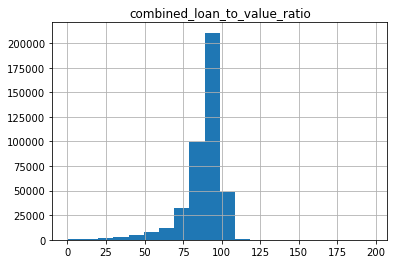

In [200]:
mortgage.hist(column='combined_loan_to_value_ratio', bins=20)

array([[<AxesSubplot:title={'center':'income_log'}>]], dtype=object)

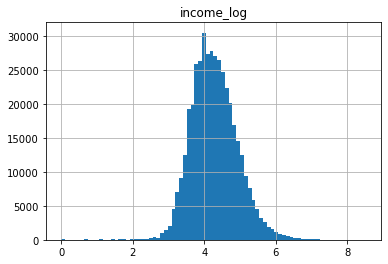

In [201]:
mortgage.hist(column='income_log', bins=80)

In [30]:
def cronbach_alpha(items):
    items = pd.DataFrame(items)
    items_count = items.shape[1]
    variance_sum = float(items.var(axis=0, ddof=1).sum())
    total_var = float(items.sum(axis=1).var(ddof=1))
    
    return (items_count / float(items_count - 1) *
            (1 - variance_sum / total_var))

mortgage.columns

Index(['activity_year', 'county_code', 'applicant_sex', 'applicant_age',
       'debt_to_income_ratio', 'combined_loan_to_value_ratio',
       'applicant_race_1', 'loan_amount_log', 'income_log', 'loan_term',
       'property_value_log', 'action_taken',
       'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
       'coapplicant_exists'],
      dtype='object')

In [31]:
cronbach_alpha(mortgage[['applicant_age', 'debt_to_income_ratio']])

0.008846125868418042

In [32]:
mortgage.corr(method = "pearson")

,applicant_age,debt_to_income_ratio,combined_loan_to_value_ratio,loan_amount_log,income_log,loan_term,property_value_log,action_taken,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage
applicant_age,1.000000,0.004443,-0.305437,0.013475,0.123106,-0.109845,0.106493,-0.017936,0.003964,0.074948
debt_to_income_ratio,0.004443,1.000000,0.193874,0.037932,-0.295610,0.121759,-0.018834,-0.165993,0.000499,-0.045279
combined_loan_to_value_ratio,-0.305437,0.193874,1.000000,0.041767,-0.194361,0.280888,-0.266406,-0.059016,-0.059152,-0.188457
loan_amount_log,0.013475,0.037932,0.041767,1.000000,0.564340,0.205654,0.868510,0.080185,0.253872,0.469835
income_log,0.123106,-0.295610,-0.194361,0.564340,1.000000,-0.099155,0.648132,0.108171,0.170353,0.406004
loan_term,-0.109845,0.121759,0.280888,0.205654,-0.099155,1.000000,0.007296,-0.002333,0.034557,-0.021938
property_value_log,0.106493,-0.018834,-0.266406,0.868510,0.648132,0.007296,1.000000,0.093134,0.287164,0.546648
action_taken,-0.017936,-0.165993,-0.059016,0.080185,0.108171,-0.002333,0.093134,1.000000,0.082421,0.074941
ffiec_msa_md_median_family_income,0.003964,0.000499,-0.059152,0.253872,0.170353,0.034557,0.287164,0.082421,1.000000,0.130789
tract_to_msa_income_percentage,0.074948,-0.045279,-0.188457,0.469835,0.406004,-0.021938,0.546648,0.074941,0.130789,1.000000


In [33]:
mortgage.dtypes

activity_year                         object
county_code                           object
applicant_sex                         object
applicant_age                          int32
debt_to_income_ratio                   int64
combined_loan_to_value_ratio         float64
applicant_race_1                      object
loan_amount_log                      float64
income_log                           float64
loan_term                            float64
property_value_log                   float64
action_taken                         float64
ffiec_msa_md_median_family_income      int64
tract_to_msa_income_percentage         int64
coapplicant_exists                    object
dtype: object

Model 1: Linear Probability Model, simple

In [205]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
mortgage_x = mortgage.loc[:, mortgage.columns != 'action_taken']
mortgage_y = mortgage['action_taken']
mortgage_ux, mortgage_uy = rus.fit_resample(mortgage_x, mortgage_y)

mortgage_resampled = pd.concat([mortgage_ux.reset_index(drop=True), mortgage_uy], axis=1)
mortgage_resampled['pandemic'] = np.where(mortgage_resampled['activity_year'] == 2020, 1, 0)

In [206]:
lpm1 = sm.formula.ols(formula ='action_taken ~ C(debt_to_income_ratio) + C(activity_year) + applicant_age*C(coapplicant_exists) + C(applicant_sex) + C(applicant_race_1)*C(pandemic) + np.power(loan_amount_log,2) + income_log*C(coapplicant_exists) + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage_resampled).fit(cor_type = "HC3")

print(lpm1.summary())

                            OLS Regression Results                            
Dep. Variable:           action_taken   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     530.3
Date:                Sat, 18 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:58:11   Log-Likelihood:                -36757.
No. Observations:               58276   AIC:                         7.356e+04
Df Residuals:                   58252   BIC:                         7.378e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

Model 2: Try curvilinear relationship - linear **this is in my report!!

In [217]:
curvy = smf.ols(formula = "action_taken ~ np.power(debt_to_income_ratio,2) + applicant_age*C(coapplicant_exists) + C(applicant_sex) + C(applicant_race_1)*C(pandemic) + np.power(loan_amount_log,2) + income_log*C(coapplicant_exists) + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage", data = mortgage_resampled).fit(cor_type = "HC3")
print(curvy.summary())

                            OLS Regression Results                            
Dep. Variable:           action_taken   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     612.6
Date:                Sun, 19 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:24:16   Log-Likelihood:                -37504.
No. Observations:               58276   AIC:                         7.504e+04
Df Residuals:                   58258   BIC:                         7.521e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [228]:
def reset_ramsey(res, degree=2):
    order = degree + 1
    k_vars = res.model.exog.shape[1]
    norm_values = np.asarray(res.fittedvalues)
    norm_values = norm_values / np.sqrt((norm_values ** 2).mean())
    y_fitted_vander = np.vander(norm_values, order)[:, :-2]
    exog = np.column_stack((res.model.exog, y_fitted_vander))
    exog /= np.sqrt((exog ** 2).mean(0))
    endog = res.model.endog / (res.model.endog ** 2).mean()
    res_aux = smf.ols(endog, exog).fit()
    r_matrix = np.eye(degree - 1, exog.shape[1], k_vars)
    return res_aux.f_test(r_matrix)  # , r_matrix, res_aux


rr = smf.ols(formula = "action_taken ~ debt_to_income_ratio + loan_amount_log + income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage", data = mortgage_resampled).fit(cor_type = "HC3")
reset_ramsey(rr, degree = 2)

array([0., 0., 0., ..., 1., 1., 1.])

In [209]:
pd.crosstab(index=mortgage_resampled['applicant_race_1'], columns = "count")

col_0,count
applicant_race_1,
0.0,49038
1.0,9238


Logit Model 1 (use categorical, no ordinal)

In [210]:
logit1 = sm.formula.logit(formula ='action_taken ~ C(debt_to_income_ratio) + C(activity_year) + applicant_age*C(coapplicant_exists) + C(applicant_sex) + C(applicant_race_1)*C(pandemic) + np.power(loan_amount_log,2) + income_log*C(coapplicant_exists) + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                          data = mortgage_resampled).fit(cor_type = "HC3")

print(logit1.summary())

Optimization terminated successfully.
         Current function value: 0.589375
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           action_taken   No. Observations:                58276
Model:                          Logit   Df Residuals:                    58252
Method:                           MLE   Df Model:                           23
Date:                Sat, 18 Dec 2021   Pseudo R-squ.:                  0.1497
Time:                        21:17:00   Log-Likelihood:                -34346.
converged:                       True   LL-Null:                       -40394.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                 

In [211]:
np.exp(logit1.params)

Intercept                                      0.039308
C(debt_to_income_ratio)[T.2]                   1.308515
C(debt_to_income_ratio)[T.3]                   1.216262
C(debt_to_income_ratio)[T.4]                   1.159084
C(debt_to_income_ratio)[T.5]                   0.839026
C(debt_to_income_ratio)[T.6]                   0.268798
C(debt_to_income_ratio)[T.7]                   0.010100
C(activity_year)[T.2019]                       1.214884
C(activity_year)[T.2020]                       1.074234
C(coapplicant_exists)[T.1]                     0.804239
C(applicant_sex)[T.2]                          1.050171
C(applicant_sex)[T.6]                          1.027087
C(applicant_race_1)[T.1.0]                     0.590256
C(pandemic)[T.1]                               1.074234
C(applicant_race_1)[T.1.0]:C(pandemic)[T.1]    0.902837
applicant_age                                  0.931909
applicant_age:C(coapplicant_exists)[T.1]       0.972099
np.power(loan_amount_log, 2)                   1

In [365]:
#switch the ordinal
logit2 = sm.formula.logit(formula ='action_taken ~ debt_to_income_ratio + C(activity_year) + applicant_age*C(coapplicant_exists) + C(applicant_sex) + C(applicant_race_1) + np.power(loan_amount_log,2) + np.power(income_log,2)*C(coapplicant_exists) + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

print(logit2.summary())

Optimization terminated successfully.
         Current function value: 0.228504
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           action_taken   No. Observations:               423080
Model:                          Logit   Df Residuals:                   423065
Method:                           MLE   Df Model:                           14
Date:                Fri, 17 Dec 2021   Pseudo R-squ.:                 0.08857
Time:                        22:45:33   Log-Likelihood:                -96675.
converged:                       True   LL-Null:                   -1.0607e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -3.1067      0.173    -17

In [366]:
np.exp(logit2.params)

Intercept                            0.044749
C(activity_year)[T.2019]             1.124260
C(activity_year)[T.2020]             1.013004
C(coapplicant_exists)[T.1]           1.014781
C(applicant_sex)[T.2]                1.079300
C(applicant_sex)[T.6]                0.962196
C(applicant_race_1)[T.1.0]           1.780160
debt_to_income_ratio                 0.635030
applicant_age                        0.924709
income_log                           1.134393
property_value_log                   1.471046
combined_loan_to_value_ratio         0.992337
loan_term                            1.001387
ffiec_msa_md_median_family_income    1.000027
tract_to_msa_income_percentage       1.002148
dtype: float64

In [214]:
#with mediators (using census tracts)
logit3 = sm.formula.logit(formula ='action_taken ~ np.power(debt_to_income_ratio,2) + applicant_age*C(coapplicant_exists) + C(applicant_sex) + C(applicant_race_1)*C(pandemic) + np.power(loan_amount_log,2) + income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage_resampled).fit(cor_type = "HC3")

print(logit3.summary())

Optimization terminated successfully.
         Current function value: 0.610188
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           action_taken   No. Observations:                58276
Model:                          Logit   Df Residuals:                    58259
Method:                           MLE   Df Model:                           16
Date:                Sun, 19 Dec 2021   Pseudo R-squ.:                  0.1197
Time:                        09:42:12   Log-Likelihood:                -35559.
converged:                       True   LL-Null:                       -40394.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                 

In [215]:
np.exp(logit3.params)

Intercept                                      0.029457
C(coapplicant_exists)[T.1]                     1.081310
C(applicant_sex)[T.2]                          1.071603
C(applicant_sex)[T.6]                          0.942176
C(applicant_race_1)[T.1.0]                     0.592807
C(pandemic)[T.1]                               1.021820
C(applicant_race_1)[T.1.0]:C(pandemic)[T.1]    0.913807
np.power(debt_to_income_ratio, 2)              0.946988
applicant_age                                  0.941548
applicant_age:C(coapplicant_exists)[T.1]       0.958690
np.power(loan_amount_log, 2)                   1.014987
income_log                                     0.914462
property_value_log                             1.215987
combined_loan_to_value_ratio                   0.987076
loan_term                                      1.000353
ffiec_msa_md_median_family_income              1.000021
tract_to_msa_income_percentage                 1.002079
dtype: float64

In [158]:

pd.crosstab(index = mortgage_resampled['activity_year'], columns = "count", normalize = True)

col_0,count
activity_year,
2018,0.336777
2019,0.324439
2020,0.338784


In [173]:
#interaction variable between race and year
logit4 = sm.formula.logit(formula ='action_taken ~ np.power(debt_to_income_ratio,2) + applicant_age*C(coapplicant_exists) + C(applicant_sex) + C(applicant_race_1)*C(pandemic) + np.power(loan_amount_log,2) + income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage_resampled).fit(cor_type = "HC3")

print(logit4.summary())

Optimization terminated successfully.
         Current function value: 0.610188
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           action_taken   No. Observations:                58276
Model:                          Logit   Df Residuals:                    58259
Method:                           MLE   Df Model:                           16
Date:                Sat, 18 Dec 2021   Pseudo R-squ.:                  0.1197
Time:                        20:00:52   Log-Likelihood:                -35559.
converged:                       True   LL-Null:                       -40394.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                 

In [169]:
from scipy.stats import bartlett
stat, p = bartlett(mortgage['income_log'], mortgage['combined_loan_to_value_ratio'])
p

0.0

In [286]:
pd.crosstab(index = mortgage["action_taken"], columns = "count")

col_0,count
action_taken,
0.0,29138
1.0,393942


In [287]:
pd.crosstab(index = mortgage["coapplicant_exists"], columns = "count")

col_0,count
coapplicant_exists,
0,162678
1,260402


In [291]:
pd.crosstab(index = mortgage["applicant_age"], columns = "count", normalize = True)

col_0,count
applicant_age,
1,0.081351
2,0.340921
3,0.238924
4,0.162151
5,0.109428
6,0.053555
7,0.013669


In [289]:
pd.crosstab(index = mortgage["applicant_race_1"], columns = "count")

col_0,count
applicant_race_1,
0.0,49928
1.0,373152


In [293]:
pd.crosstab(index = mortgage["debt_to_income_ratio"], columns = "count", normalize = True)

col_0,count
debt_to_income_ratio,
1,0.074879
2,0.218332
3,0.192713
4,0.292032
5,0.157928
6,0.051867
7,0.012248


In [ ]:
mortgage.cov()

In [216]:
mortgage_resampled.to_csv('C:/Users/Cindy C/Documents/CINDY CHEN/2021 Prep/SCHOOL WORK/QMSS GR5015 - Data Analysis/Final Project/mortgage_data.csv', index = False)

In [154]:
mortgage.dtypes

activity_year                     int64
county_code                      object
applicant_sex                    object
co_applicant_race_1              object
co_applicant_sex                 object
applicant_age                    object
co_applicant_age                 object
debt_to_income_ratio             object
combined_loan_to_value_ratio    float64
applicant_race_1                float64
loan_amount_log                 float64
income_log                      float64
loan_term                       float64
property_value_log              float64
action_taken                    float64
dtype: object

Not really applicable to situation (Quantile Regression)

In [380]:
quantreg_model = smf.quantreg('action_taken ~ debt_to_income_ratio + C(activity_year) + applicant_age*C(coapplicant_exists) + applicant_age + C(coapplicant_exists) + C(applicant_sex) + C(applicant_race_1) + income_log + property_value_log + np.power(combined_loan_to_value_ratio,2) + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage', mortgage).fit()
quantreg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:           action_taken   Pseudo R-squared:           -9.786e-07
Model:                       QuantReg   Bandwidth:                   4.874e-09
Method:                 Least Squares   Sparsity:                    3.164e-07
Date:                Sat, 18 Dec 2021   No. Observations:               423080
Time:                        11:04:43   Df Residuals:                   423064
                                        Df Model:                           15
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     1.0000   6.58e-09   1.52e+08      0.000       1.000       1.000
C(activity_year)[T.2019]                   8.446e-09   6.06e-10     13.948      0.000    7.26e-09    9.63e-09
C(activity_year)[T.2020]                  -4.864e-09   6.18e-10     -7.876      0.000   -6.07e-09   -3.65e-09
C(coapplicant_exists)[T.1]                 2.385e-08   1.25e-09     19.038      0.000    2.14e-08    2.63e-08
C(applicant_sex)[T.2]                      4.124e-09   5.24e-10      7.863      0.000     3.1e-09    5.15e-09
C(applicant_sex)[T.6]                     -2.685e-09   8.53e-09     -0.315      0.753   -1.94e-08     1.4e-08
C(applicant_race_1)[T.1.0]                 6.279e-08    7.7e-10     81.520      0.000    6.13e-08    6.43e-08
debt_to_income_ratio                       -3.55e-08   1.96e-10   -181.371      0.000   -3.59e-08   -3.51e-08
applicant_age                             -2.714e-09    2.8e-10     -9.709      0.000   -3.26e-09   -2.17e-09
applicant_age:C(coapplicant_exists)[T.1]  -6.832e-09   3.57e-10    -19.116      0.000   -7.53e-09   -6.13e-09
income_log                                 7.014e-09   5.62e-10     12.492      0.000    5.91e-09    8.12e-09
property_value_log                         1.778e-08   6.25e-10     28.431      0.000    1.66e-08     1.9e-08
np.power(combined_loan_to_value_ratio, 2) -3.955e-12   1.35e-13    -29.261      0.000   -4.22e-12   -3.69e-12
loan_term                                  1.236e-10   5.14e-12     24.057      0.000    1.14e-10    1.34e-10
ffiec_msa_md_median_family_income          3.466e-12   3.42e-14    101.414      0.000     3.4e-12    3.53e-12
tract_to_msa_income_percentage             2.047e-10   7.32e-12     27.951      0.000     1.9e-10    2.19e-10
=============================================================================================================

The condition number is large, 2.56e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Not really applicable to situation (Robust Regression)

In [382]:
lm_model = smf.rlm('action_taken ~ debt_to_income_ratio + C(activity_year) + applicant_age*C(coapplicant_exists) + applicant_age + C(coapplicant_exists) + C(applicant_sex) + C(applicant_race_1) + income_log + property_value_log + np.power(combined_loan_to_value_ratio,2) + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage', mortgage).fit()
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           action_taken   No. Observations:               423080
Model:                            RLM   Df Residuals:                   423064
Method:                          IRLS   Df Model:                           15
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 18 Dec 2021                                         
Time:                        11:10:31                                         
No. Iterations:                    50                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     1.0000   1.31e-14   7.63e+13      0.000       1.000       1.000
C(activity_year)[T.2019]                  -2.019e-13   1.21e-15   -167.349      0.000   -2.04e-13      -2e-13
C(activity_year)[T.2020]                  -6.328e-13   1.23e-15   -514.139      0.000   -6.35e-13    -6.3e-13
C(coapplicant_exists)[T.1]                 1.148e-14    2.5e-15      4.601      0.000    6.59e-15    1.64e-14
C(applicant_sex)[T.2]                      2.008e-15   1.05e-15      1.922      0.055   -4.01e-17    4.06e-15
C(applicant_sex)[T.6]                      1.397e-14    1.7e-14      0.822      0.411   -1.93e-14    4.73e-14
C(applicant_race_1)[T.1.0]                  3.79e-14   1.53e-15     24.694      0.000    3.49e-14    4.09e-14
debt_to_income_ratio                      -2.112e-14    3.9e-16    -54.158      0.000   -2.19e-14   -2.04e-14
applicant_age                             -1.679e-15   5.57e-16     -3.014      0.003   -2.77e-15   -5.87e-16
applicant_age:C(coapplicant_exists)[T.1]   -3.92e-15   7.12e-16     -5.503      0.000   -5.32e-15   -2.52e-15
income_log                                 4.191e-15   1.12e-15      3.745      0.000       2e-15    6.38e-15
property_value_log                         1.085e-14   1.25e-15      8.706      0.000    8.41e-15    1.33e-14
np.power(combined_loan_to_value_ratio, 2) -6.152e-18   2.69e-19    -22.841      0.000   -6.68e-18   -5.62e-18
loan_term                                  7.344e-17   1.02e-17      7.172      0.000    5.34e-17    9.35e-17
ffiec_msa_md_median_family_income          2.764e-18   6.81e-20     40.576      0.000    2.63e-18     2.9e-18
tract_to_msa_income_percentage             1.189e-16   1.46e-17      8.149      0.000    9.03e-17    1.48e-16
=============================================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

Used this section to run some ANOVA tests

In [134]:
#DEBT TO INCOME RATIO

new_df = pd.concat([mortgage.property_value_log,
                    mortgage.income_log,
                    mortgage.loan_amount_log,
                    mortgage.tract_to_msa_income_percentage,
                    mortgage.ffiec_msa_md_median_family_income,
                    mortgage.combined_loan_to_value_ratio,
                    mortgage.loan_term,
                    mortgage.action_taken,
                   pd.get_dummies(mortgage.debt_to_income_ratio, prefix = 'debt')], axis = 1)

new_df.columns


partial_ftest_2 = sm.formula.ols(formula ='action_taken ~ + debt_1 + debt_2 + debt_3 + debt_4 + debt_5 + debt_6 + debt_7 + np.power(loan_amount_log,2) + income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = new_df).fit(cor_type = "HC3")

partial_ftest_1 = sm.formula.ols(formula ='action_taken ~ income_log + np.power(loan_amount_log,2)+ property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

sm.stats.anova_lm(partial_ftest_1, partial_ftest_2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,423072.0,26635.160920,0.0,NaN,NaN,NaN
1,423066.0,23294.824822,6.0,3340.336098,10110.848241,0.0


In [133]:
#ACTIVITY YEAR
new_df = pd.concat([mortgage.property_value_log,
                    mortgage.income_log,
                    mortgage.loan_amount_log,
                    mortgage.tract_to_msa_income_percentage,
                    mortgage.ffiec_msa_md_median_family_income,
                    mortgage.combined_loan_to_value_ratio,
                    mortgage.loan_term,
                    mortgage.action_taken,
                   pd.get_dummies(mortgage.activity_year, prefix = 'year')], axis = 1)

partial_ftest_2 = sm.formula.ols(formula ='action_taken ~ + year_2018 + year_2019 + year_2020 + np.power(loan_amount_log,2)+ income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = new_df).fit(cor_type = "HC3")

partial_ftest_1 = sm.formula.ols(formula ='action_taken ~ income_log + np.power(loan_amount_log,2) + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

sm.stats.anova_lm(partial_ftest_1, partial_ftest_2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,423072.0,26635.160920,0.0,NaN,NaN,NaN
1,423070.0,26629.271584,2.0,5.889336,46.783132,4.837156e-21


In [131]:
#SEX

new_df = pd.concat([mortgage.property_value_log,
                    mortgage.income_log,
                    mortgage.loan_amount_log,
                    mortgage.tract_to_msa_income_percentage,
                    mortgage.ffiec_msa_md_median_family_income,
                    mortgage.combined_loan_to_value_ratio,
                    mortgage.loan_term,
                    mortgage.action_taken,
                   pd.get_dummies(mortgage.applicant_sex, prefix = 'sex')], axis = 1)

new_df.columns


partial_ftest_2 = sm.formula.ols(formula ='action_taken ~ + sex_1 + sex_2 + sex_6 + income_log + np.power(loan_amount_log,2) + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = new_df).fit(cor_type = "HC3")

partial_ftest_1 = sm.formula.ols(formula ='action_taken ~ income_log + property_value_log + np.power(loan_amount_log,2) + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

sm.stats.anova_lm(partial_ftest_1, partial_ftest_2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,423072.0,26635.160920,0.0,NaN,NaN,NaN
1,423070.0,26635.121139,2.0,0.039781,0.315942,0.729102


In [132]:
#AGE

new_df = pd.concat([mortgage.property_value_log,
                    mortgage.income_log,
                    mortgage.loan_amount_log,
                    mortgage.tract_to_msa_income_percentage,
                    mortgage.ffiec_msa_md_median_family_income,
                    mortgage.combined_loan_to_value_ratio,
                    mortgage.loan_term,
                    mortgage.action_taken,
                   pd.get_dummies(mortgage.applicant_age, prefix = 'age')], axis = 1)

partial_ftest_2 = sm.formula.ols(formula ='action_taken ~ + age_1 + age_2 + age_3 + age_4 + age_5 + age_6 + age_7 + np.power(loan_amount_log,2)+ income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = new_df).fit(cor_type = "HC3")

partial_ftest_1 = sm.formula.ols(formula ='action_taken ~ income_log + np.power(loan_amount_log,2) + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

sm.stats.anova_lm(partial_ftest_1, partial_ftest_2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,423072.0,26635.160920,0.0,NaN,NaN,NaN
1,423066.0,26542.422292,6.0,92.738628,246.363853,1.024672e-315


In [141]:
#income_log

new_df = pd.concat([mortgage.property_value_log,
                    mortgage.income_log,
                    mortgage.loan_amount_log,
                    mortgage.tract_to_msa_income_percentage,
                    mortgage.ffiec_msa_md_median_family_income,
                    mortgage.combined_loan_to_value_ratio,
                    mortgage.loan_term,
                    mortgage.action_taken,
                   pd.get_dummies(mortgage.applicant_age, prefix = 'age')], axis = 1)

partial_ftest_2 = sm.formula.ols(formula ='action_taken ~ np.power(loan_amount_log,2)+ np.power(income_log,3) + income_log + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = new_df).fit(cor_type = "HC3")

partial_ftest_1 = sm.formula.ols(formula ='action_taken ~ income_log + np.power(loan_amount_log,2) + property_value_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

sm.stats.anova_lm(partial_ftest_1, partial_ftest_2)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,423072.0,26635.160920,0.0,NaN,NaN,NaN
1,423071.0,26477.150496,1.0,158.010424,2524.804478,0.0


VIF Calculation

In [339]:
logit_test = sm.formula.logit(formula ='action_taken ~  income_log + property_value_log + loan_amount_log + combined_loan_to_value_ratio + loan_term + ffiec_msa_md_median_family_income + tract_to_msa_income_percentage',
                        data = mortgage).fit(cor_type = "HC3")

def vif(fit): 
    from statsmodels.stats.outliers_influence import variance_inflation_factor as smvif
    from patsy import dmatrix
    x = fit.model.data
    dicty = x.frame.to_dict('list') # Convert DataFrame to dictionary. Dict-like {column -> [values]}
    formula_like = '+'.join(x.xnames[1:])  # produce formula_like such as "a + b"
    design_matrix = dmatrix(formula_like, dicty)
    for item in range(1, len(x.xnames)):
        print (x.xnames[item] + ': ' + str(smvif(design_matrix, item)))

vif(logit_test)

Optimization terminated successfully.
         Current function value: 0.241498
         Iterations 7
income_log: 1.7764016306339376
property_value_log: 7.782303577573573
loan_amount_log: 6.675169449008721
combined_loan_to_value_ratio: 1.6163464526636881
loan_term: 1.2296642749024609
ffiec_msa_md_median_family_income: 1.0926206163530265
tract_to_msa_income_percentage: 1.4414446331753075


In [358]:
dir(sm.stats)

['CompareCox',
 'CompareJ',
 'CompareMeans',
 'DescrStatsW',
 'Describe',
 'FTestAnovaPower',
 'FTestPower',
 'FactoredPSDMatrix',
 'GofChisquarePower',
 'HetGoldfeldQuandt',
 'Mediation',
 'NormalIndPower',
 'NullDistribution',
 'OaxacaBlinder',
 'RegressionFDR',
 'Runs',
 'SquareTable',
 'StratifiedTable',
 'TTestIndPower',
 'TTestPower',
 'Table',
 'Table2x2',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'acorr_breusch_godfrey',
 'acorr_ljungbox',
 'acorr_lm',
 'anova_lm',
 'binom_test',
 'binom_test_reject_interval',
 'binom_tost',
 'binom_tost_reject_interval',
 'breaks_cusumolsresid',
 'breaks_hansen',
 'chisquare_effectsize',
 'cochrans_q',
 'compare_cox',
 'compare_encompassing',
 'compare_j',
 'corr_clipped',
 'corr_nearest',
 'corr_nearest_factor',
 'corr_thresholded',
 'cov_cluster',
 'cov_cluster_2groups',
 'cov_hac',
 'cov_hc0',
 'cov_hc1',
 'cov_hc2',
 'cov_hc3',
 'cov_nearest',
 'cov_neares

Factor Analysis

In [389]:
mortgage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423080 entries, 0 to 1017671
Data columns (total 14 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   activity_year                      423080 non-null  object 
 1   applicant_sex                      423080 non-null  object 
 2   applicant_age                      423080 non-null  int32  
 3   debt_to_income_ratio               423080 non-null  int64  
 4   combined_loan_to_value_ratio       423080 non-null  float64
 5   applicant_race_1                   423080 non-null  object 
 6   loan_amount_log                    423080 non-null  float64
 7   income_log                         423080 non-null  float64
 8   loan_term                          423080 non-null  float64
 9   property_value_log                 423080 non-null  float64
 10  action_taken                       423080 non-null  float64
 11  ffiec_msa_md_median_family_income  423

In [35]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(mortgage)
chi_square_value, p_value

C:\Users\Cindy C\anaconda4\lib\site-packages\factor_analyzer\utils.py:92: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x = (x - x.mean(0)) / x.std(0)


TypeError: unsupported operand type(s) for -: 'str' and 'float'

0.0    29138
1.0    29138
Name: action_taken, dtype: int64
